In [12]:
import ee 
import shapely as shp
import pandas as pd
import numpy as np
import geopandas as gpd
import ast
from shapely.geometry import Polygon, MultiPolygon, Point
import rasterio
import geopandas as gpd
import sys
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '/Users/gr_1/Documents/simplem/')
import simplem_par as simplem
import matplotlib.pyplot as plt
import multiprocess as mp
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Clip Basins

In [52]:
eros1 = np.load('ers_diffu+sp.npy',allow_pickle=True)

In [53]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [54]:
image = ee.Image("WWF/HydroSHEDS/3CONDEM");
bBox = ee.Geometry.BBox(112, -40, 165, -8);
image = image.clip(bBox)

In [55]:
a = gpd.read_file('/Users/gr_1/Documents/cosmo_predict/octo_327_data')

In [30]:
a.to_file('atest')

In [59]:
import json 
from ee.geometry import Geometry
basin_slopes = gpd.GeoDataFrame()
basin_slopes_t = gpd.GeoDataFrame()

shps = []
for i,row in a.iterrows():
    try:
        sh = list(zip(row.geometry.exterior.coords.xy[0],row.geometry.exterior.coords.xy[1]))
    except:
        sh = list(zip(row.geometry[1].exterior.coords.xy[0],row.geometry[1].exterior.coords.xy[1]))
    shp = Geometry.Polygon(sh)
    shps.append(shp)

In [ ]:
bas =  os.listdir('/Users/gr_1/Google Drive/data_earth_engine')
for i in range(0,3553):
    nm ='hydrosheds_bas_' + str(i) +'.tif'
    if  nm not in bas:
        print(nm)

In [ ]:
c=0
while c < 2258:
    c+=1
    image = ee.Image("WWF/HydroSHEDS/03CONDEM");
    image = image.clip(shps[c])
    mytask = ee.batch.Export.image.toDrive(image=image, folder='data_earth_engine', description='hydrosheds_bas_'+ str(c))
    mytask.start()

In [ ]:
f = simplem.fs()
f.sinkfill()

In [ ]:
plt.plot(np.log(eromap[0:30]))

## Start running flowacc / chi calc on all basin

In [13]:
import ee 
import shapely as shp
import pandas as pd
import numpy as np
import geopandas as gpd
import ast
from shapely.geometry import Polygon, MultiPolygon, Point
import rasterio
import geopandas as gpd
import sys
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '/Users/gr_1/Documents/simplem/')
import simplem_par as simplem
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
eros1 = [None]*3600
eros2 = np.zeros(3600)
slpsall = np.zeros(3600)
slps2 = np.zeros(3600)
a = gpd.read_file('/Users/gr_1/Documents/cosmo_predict/octo_327_data')

In [22]:
nr = 1000
Gs = np.zeros(nr) #+ np.random.rand(nr)*15.0
ks = np.zeros(nr) + np.power(10.0,np.random.rand(nr)*-8+-5)
ns = np.random.rand(nr) * 4.0 #np.zeros(nr)+2.7#
ms = ns * 0.5 #np.zeros(nr)+1.0
#concavity = np.random.rand(nr)*.6+.1
diffus =ks * np.power(10.0,np.random.rand(nr)*10)#np.zeros(nr)+1e-5#
#ms = ns * concavity
careas = np.power(10.0,np.random.rand(nr)*3)*0+12

In [7]:
nr = 1
Gs = np.zeros(nr) #+ np.random.rand(nr)*15.0
ks =  np.power(10.0,np.linspace(-10,-3,nr))
ns = np.zeros(nr) +4
ms = np.zeros(nr)+2
#ns = np.array([np.linspace(.2,4,nr)]*10).ravel() #np.zeros(nr)+2.7#
#ms = np.array([np.linspace(.2,4,nr) * s for s in [.1, .2, .3, .35, .4, .45, .5, .55, .6, .7]]).ravel()  #np.zeros(nr)+1.0
concavity = np.zeros(nr)+.5#np.random.rand(nr)*.6+.1
diffus = 0*ks* np.power(10.0,np.random.rand(nr)*10-1)#np.zeros(nr)+1e-5#
#ms = ns * concavity
careas = np.zeros(nr)+12#np.zeros(nr)+12#np.power(10.0,np.random.rand(nr)*3)*5

In [23]:

n = 3553
def do_ero(i):
    k1[k1>0] = ks[i]
    E = simplem.diffuse(-diffus[i],Zi,dy1,dx1,dt1)
    E[E<0] = 0
    m = ms[i]
    n = ns[i]
    #E[A1<careas[i]] = 0
    ero = simplem.erode_other_2(Gs[i],ny1,nx1,I1,s1,dx1,dy1,ms[i],ns[i],k1,slps1,dt1,A1,E,careas[i])
    A = simplem.acc(ero.copy(), ny1, nx1, I1, s1)
    pl =(A.ravel()[np.argmax(A1.ravel())])/np.max(A1.ravel())
    return pl, i
nfail = 0
for c in range(1,n):
    try:
        print(c)

        dem = rasterio.open('/Users/gr_1/Google Drive/data_earth_engine/hydrosheds_bas_{}.tif'.format(str(c)))
        lat = dem.xy(0,0)[1]
        dx = np.cos(lat/180*np.pi) * (1852/60)
        f = simplem.fs()
        f.dx = dx
        f.dy = 92.59


        f.set_z(np.float64(np.squeeze(dem.read())))
        f.BC = np.where(f.Z.transpose().ravel()<=0)[0]
        f.slp_basin()
        slpx= f.slps.copy()

        f.k[:,:] = 1e-6
        f.k[f.Z == 0] = 0

        f.sinkfill()
        f.slp_basin()

        #f.slp_mn()
        slps = f.slps.copy()

        f.dt = 1000
        f.stack()
        f.acc()

        Zi = f.Z.copy()
        A1=f.A.copy()

        ero = f.erode_other()
        #f.slp_mn()

       # slps[slps>1]= 0
        #f.slp()
        mnmat = np.zeros((len(ms),1))
        if 1:
            k1 = f.k.copy()

            A1 = f.A.copy()
            ny1 = f.ny
            nx1 = f.nx
            I1 = f.I.copy()
            slps1 = f.slps.copy()
            s1 = f.s
            dt1 = f.dt
            dy1 =f.dy
            dx1 = f.dx
            with mp.Pool(6) as p:
                vals = p.map(do_ero,[i for i in range(len(ns))])

        eros1[c] = mnmat[ list(zip(*vals))[1],0] =  list(zip(*vals))[0]
        #fig,ax = plt.subplots(figsize=(5,5))
        #plt.imshow(vals[0][2])
        #eros1[c] = (f.A.ravel()[f.Z.ravel()>0][np.argmax(A.ravel()[f.Z.ravel() > 0])])/np.max(A.ravel()[f.Z.ravel()>0])
        #A2 = simplem.acc(slpx, ny1,nx1,I1,s1)
        #slpsall[c] = (A2.ravel()[np.argmax(A1.ravel())])/np.max(A1.ravel())

        #slps1[c] = np.mean(np.logical_and(slps[f.Z>0]))

      #  f.slp_mn()

       # slps = f.slps.copy()
      #  f.slp()
       # slps[slps>1] = 0
       # f.acc(slps)
       # slps2[c] = (f.A.ravel()[f.Z.ravel()>0][np.argmax(A.ravel()[f.Z.ravel() > 0])])/np.max(A.ravel()[f.Z.ravel()>0])

       # print(np.mean(f.slps.ravel()[A.ravel()>1]))
       # print(f.A.ravel()[np.argmax(A.ravel())]/np.max(A.ravel()))
        #print(np.sum(slps.ravel()[np.logical_and(f.Z.ravel()>1,f.slps.ravel()<1)]))
       # print(max(f.A.ravel()))#[np.argmax(A.ravel())])

    except Exception as e:
        print('fail' + str(c))
        print(e)
        po=1
        nfail+=1
                      

1
191917
159035
2
112784
102935
3
3432928
3236678
4
1239777
1156773
5
1054570
985543
6
795624
733902
7
850821
789058
8
858685
799660
9
671729
617031
10
786552
711293
11
796235
766538
12
73284
65016
13
71528
69596
14
19
19
15
62261
57944
16
22
22
17
60
59
18
44697
41720
19
66
66
20
20
19
21
46
46
22
29792
27112
23
23299
22237
24
60008
58836
25
127
125
26
83
81
27
66560
63224
28
54
54
29
32
32
30
28662
27440
31
27595
26646
32
21
21
33
2
2
34
8
8
35
0
0
36
1
1
37
1
1
38
1
0
39
785611
722681
40
897056
877447
41
5568645
5161605
42
17
17
43
2518943
2432234
44
1487
1473
45
7939
7616
46
429167
406954
47
82600
80571
48
158663
156880
49
155091
153312
50
10791
10617
51
4393029
3989985
52
391530
382423
53
30403
30009
54
56760
51733
55
59815
59101
56
19709
18258
57
829979
801256
58
209742
194815
59
39720
39155
60
13417
12789
61
1513
1336
62
244
224
63
248
230
64
10
8
65
884
883
66
37
37
67
3360
3287
68
186
186
69
59507
59132
70
70029
69411
71
30871
30224
72
1587
1583
73
562
560
74
489
488
75
14
12


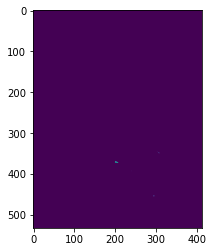

In [98]:
plt.imshow((vals[0][2]+.01),vmax=1e6)

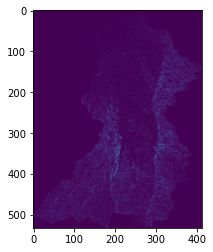

In [118]:
plt.imshow(slps)

In [116]:
slps.ravel()[np.argmax(vals[0][2].ravel())]

0.41869696779154963

In [115]:
.418696**4*1e-10*17990**2*7041919*1000

7004039.707407377

Text(0, 0.5, 'Avg surface slope (m/m)')

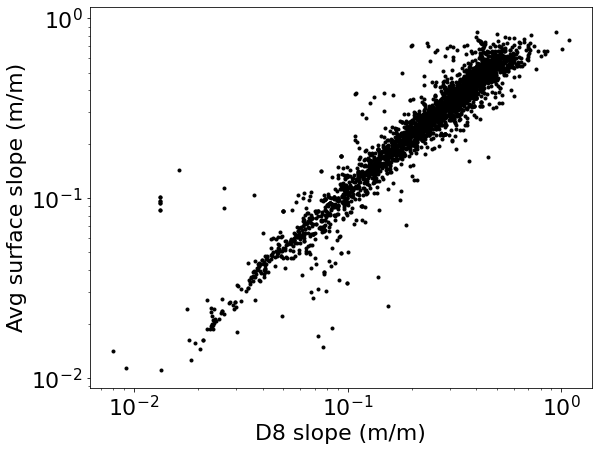

In [332]:
fig,ax = plt.subplots(figsize=(9,7))

plt.plot(slpsall[:len(a)],a['slp_ave']/1000,'k.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('D8 slope (m/m)')
plt.ylabel('Avg surface slope (m/m)')

Text(0, 0.5, 'Observed erosion rate (mm/kyr)')

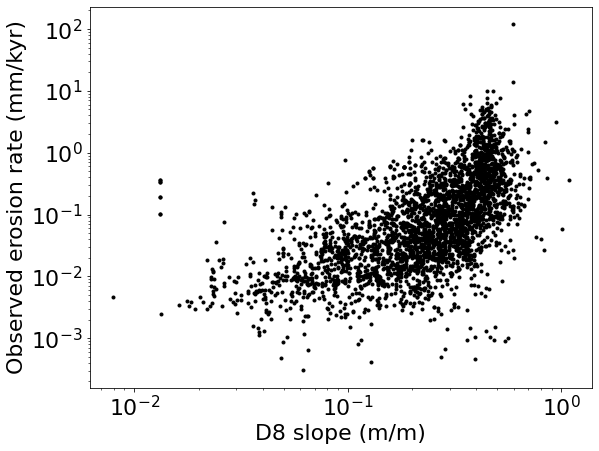

In [334]:
fig,ax = plt.subplots(figsize=(9,7))

plt.plot(slpsall[:len(a)],a['ebe_mmkyr']/1000,'k.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('D8 slope (m/m)')
plt.ylabel('Observed erosion rate (mm/kyr)')

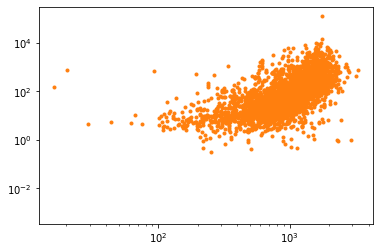

In [210]:
plt.plot(np.log10(ks2),r2s,'.')
ro = np.where(r2s>.01)[0][5]
plt.plot(dfs[ro][:len(a)],a['ebe_mmkyr'], '.')
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'count')

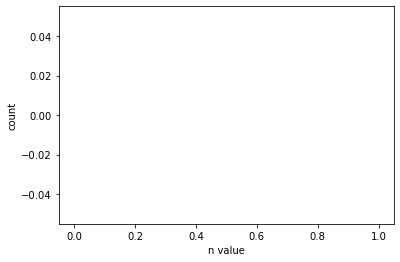

In [185]:
plt.hist(np.log10(diffus[r2s<3.4]))
plt.xlabel('n value')
plt.ylabel('count')

In [27]:
plt.plot(dfs[np.argmax(r2s)],a['ebe_mmkyr'],'.')

NameError: name 'dfs' is not defined

In [10]:
plt.plot((ns),r2s,'.')
ns[np.argmax(r2s)]

NameError: name 'r2s' is not defined

In [ ]:
plt.plot((ns),r2s,'.')
ns[np.argmax(r2s)]

In [53]:
ls = gpd.read_file('/Users/gr_1/Downloads/River_basin_num2/River_basin_num2.shp')
#ls.Volume.sum()*1e2*2700/1e9

In [54]:
ls.to_file('/Users/gr_1/Downloads/river_bsn')

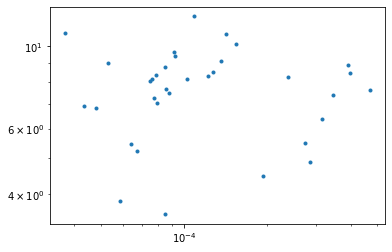

In [163]:
len(np.where(a['ebe_mmkyr'] ==0)[0])

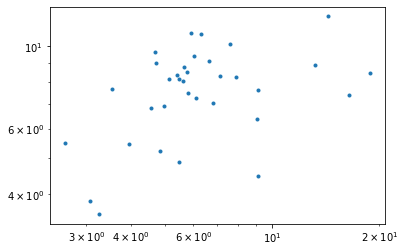

In [15]:
plt.plot(dfs[4][:35],a['ebe_mmkyr'][:35],'.')
plt.xscale('log')
plt.yscale('log')

In [81]:
dfs[1][:37]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [44]:
#plt.plot(dfs[10,0],a['ebe_mmkyr'],'.')
#plt.xscale('log')
#plt.yscale('log')
#np.save('ers_diffu+sp',eros1)
#a= plt.plot(ks,r2s[:,0],'.')
#plt.xscale('log')
#plt.hist(concavities)
plt.plot(diffus[r2s>.15]),bins=10)


[autoreload of simplem_par failed: Traceback (most recent call last):
  File "/Users/gr_1/opt/miniconda3/envs/ee/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/gr_1/opt/miniconda3/envs/ee/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/gr_1/opt/miniconda3/envs/ee/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/gr_1/opt/miniconda3/envs/ee/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 790, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/gr_1/Documents/simplem/simplem_par.py", line 121, in <module>
    class fs:
  File "/Users/gr_1/Documents/simplem/si

SyntaxError: cannot assign to function call (<ipython-input-44-c3338ce9b13d>, line 8)

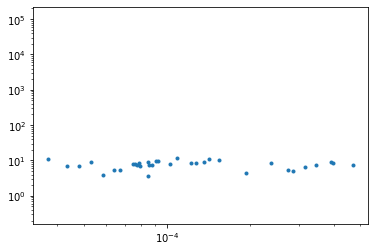

In [168]:
plt.plot(dfs[0][:len(a)],a['ebe_mmkyr'],'.')
plt.xscale('log')
plt.yscale('log')

In [24]:
folder = 'results/r_mn05_2'
if 1:
    np.save('{}/eros'.format(folder),eros1)
    np.save('{}/diffu'.format(folder),diffus)
    np.save('{}/ms'.format(folder),ms)
    np.save('{}/ns'.format(folder),ns)
    np.save('{}/ks'.format(folder),ks)
    np.save('{}/careas'.format(folder),careas)
    np.save('{}/Gs'.format(folder),Gs)
    np.save('{}/careas'.format(folder),careas)

In [164]:
eros1 = np.load('r_sole/eros.npy',allow_pickle=True)

In [42]:
len(ns)

1

In [222]:
#eros2 = np.load('eros_with_diffusion-var_hills.npy',allow_pickle=True)
folder = 'results/r_G_1'
ns = np.load('{}/ns.npy'.format(folder),allow_pickle=True)
ms = np.load('{}/ms.npy'.format(folder),allow_pickle=True)
diffus = np.load('{}/diffu.npy'.format(folder),allow_pickle=True)
eros1 = np.load('{}/eros.npy'.format(folder),allow_pickle=True)

In [192]:
for i in range(1,len(eros1)):
    if eros1[i] is None:
        continue
    else:
        eros1[i] = np.concatenate([eros1[i],eros2[i]])

In [15]:
plt.plot(slpsx[:len(a)],a['slp_ave']/1000,'.')
plt.plot(np.arange(1e-2,1.0,1e-2),np.arange(1e-2,1.0,1e-2),'.')
plt.yscale('log')
plt.xscale('log')

NameError: name 'slpsx' is not defined

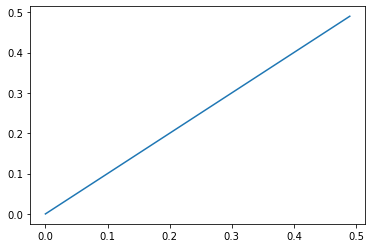

In [135]:
plt.plot(np.arange(0,.5,.01),np.arange(0,.5,.01))

In [8]:
np.a['slps1'] = slps1[:len(a)]

In [9]:
np.from sklearn import linear_model

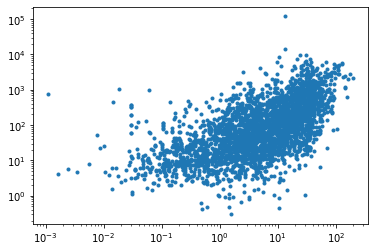

In [63]:
plt.plot(dfs[0][:len(a)], a['ebe_mmkyr'],'.')
plt.xscale('log')
plt.yscale('log')

In [ ]:
eros1[1:]*=1000000

## Begin other thing

In [223]:
#@jit(nopython=True)
#def loop_results(eros1, dfs,n,c):
n = 35#3553
nt = 1000
dfs = np.array([None]*len(eros1[1]))
              
c=0
for i in range(len(eros1[1])):
        dfs[i] = np.zeros(len(eros1))
        for k in range(1,len(eros1)):
            if (eros1[k] is None):
                continue
            else:
                dfs[i][k] = eros1[k][i]
            c+=1
    #return dfs
            

In [228]:
from sklearn import linear_model as lm
import sklearn
r2s = np.zeros(len(eros1[1]))
resid = np.zeros(len(eros1[1]))
pcoef = np.zeros(len(eros1[1]))
ks2 = ks.copy()
diffus2 = diffus.copy()
for i in range(len(eros1[1])):#range(len(ms)):
        if dfs[i] is None:
            continue
        
        y = np.log(np.float64(a['ebe_mmkyr'])/1000)
        x = np.log(dfs[i][:len(a)])
        #I_min = np.where(a['slp_ave'][:n]/1000>1e-1)[0]
        #x=x[I_min]
        #y=y[I_min]
        xi = x.copy()
        I = np.where(np.logical_or(np.isnan(x),np.isinf(x)))[0]
        x=np.delete(x,I)
        y=np.delete(y,I)
        I2 = np.where(np.logical_or(np.isnan(y),np.isnan(x)))[0]
        x = np.delete(x,I2)
        y = np.delete(y,I2)
        l1  = lm.LinearRegression(fit_intercept=False)
        l = lm.LinearRegression()
        if len(x[np.logical_not(np.isnan(x))])>n-500:
                print(len(x[np.logical_not(np.isnan(x))]))
                p1 = l1.fit(np.exp(x.reshape(-1,1)),np.exp(y.reshape(-1,1)))
                p = l.fit(x.reshape(-1,1), y.reshape(-1,1 ))

                y2 = p.predict(x.reshape(-1,1))
                y3 = x * p.coef_
                r2s[i] = sklearn.metrics.r2_score(y.reshape(-1,1),y2)
                diffus2[i] *= p1.coef_
                ks2[i] *= p1.coef_
                resid[i] = np.mean(np.power(y-y3,2))
                print(len(y[np.logical_not(np.isnan(x))]))
                pcoef[i] = p.coef_


<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by z

3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3194
3194
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192


<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by z

3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192


<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by z

3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193


<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by z

3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194


<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by z

3193
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3194
3194
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192


<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by z

3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3193
3193
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192


<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by z

3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3194
3194
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3193
3193
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3194
3194
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192
3192


<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-228-f073d45b3e13>:13: RuntimeWarning: divide by z

Text(0, 0.5, 'r2')

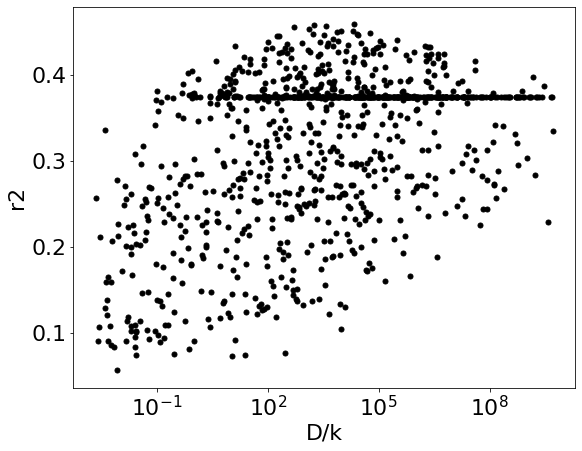

In [277]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (9,7))
plt.plot((diffus/ks),r2s,'k.', markersize=10)
plt.xscale('log')
plt.xlabel('D/k')
plt.ylabel('r2')


Text(0, 0.5, 'r2')

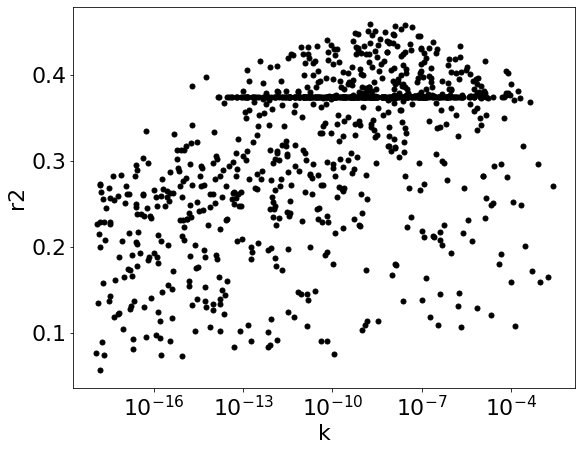

In [285]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (9,7))
plt.plot((ks2),r2s,'k.', markersize=10)
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('r2')


Text(0, 0.5, 'run count')

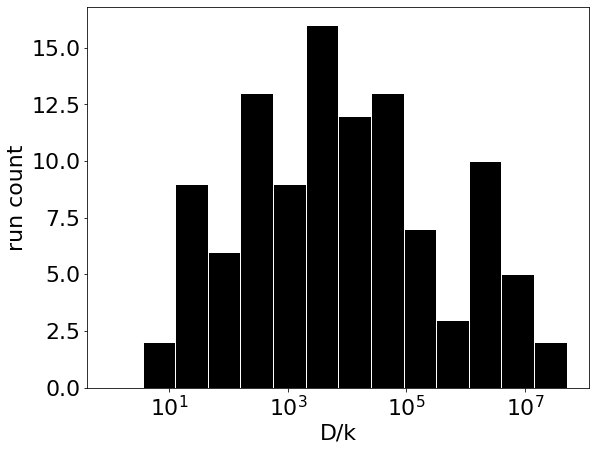

In [289]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (9,7))
plt.hist(np.divide(diffus[r2s>.4],ks[r2s>.4]),edgecolor='w',color='k',bins = np.power(10.0,np.arange(0,8,.55)))
plt.xscale('log')
plt.xlabel('D/k')
plt.ylabel('run count')

In [259]:
np.power(10,np.arange(-10,-4))

ValueError: Integers to negative integer powers are not allowed.

Text(0, 0.5, 'run count')

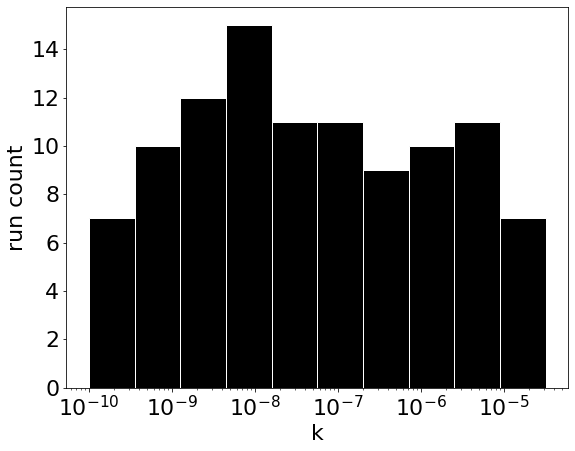

In [270]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (9,7))
plt.hist((ks[r2s>.4]),edgecolor='w',color='k',bins = np.power(10.0,np.arange(-10,-4,.55)))
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('run count')

Text(0, 0.5, 'r2')

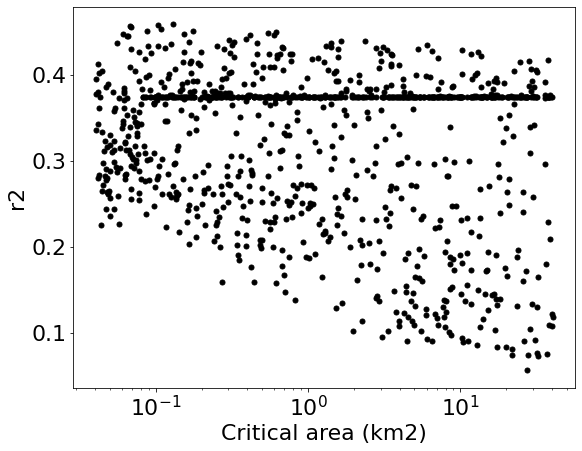

In [293]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (9,7))
plt.plot((careas)*90**2/1e6,r2s,'k.', markersize=10)
plt.xscale('log')
plt.xlabel('Critical area (km2)')
plt.ylabel('r2')


Text(0, 0.5, 'run count')

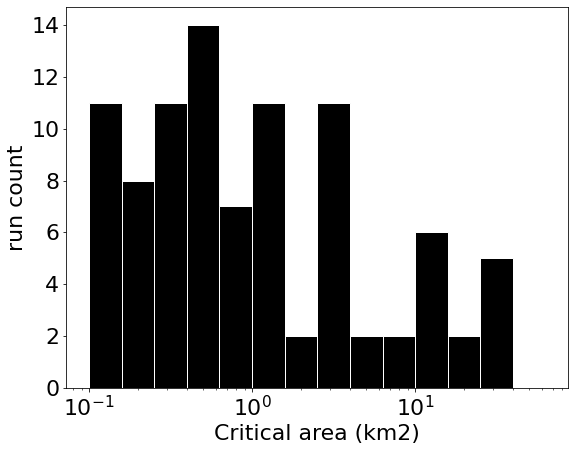

In [304]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (9,7))
plt.hist(careas[r2s>.4]*90**2/1e6,edgecolor='w',color='k',bins = np.power(10.0,np.arange(-1,2,.2)))
plt.xscale('log')
plt.xlabel('Critical area (km2)')
plt.ylabel('run count')

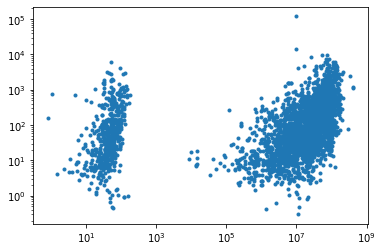

In [122]:
#plt.hist(plt.plot(diffus[r2s>.4]))
#plt.plot(dfs[np.argmax(r2s)][:len(a)],a['ebe_mmkyr'],'.')


In [15]:
ks

array([1.35171591e-05, 2.47521956e-04, 8.90428269e-08, 4.44249167e-06,
       3.04726137e-03, 1.07334156e-04, 1.22966890e-05, 7.73824977e-05,
       2.22489836e-09, 3.70245556e-03, 7.16858240e-07, 5.63449033e-08])

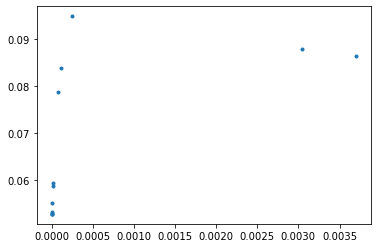

In [14]:
plt.plot(ks,r2s,'.')
#plt.xscale('log')
#plt.yscale('log')

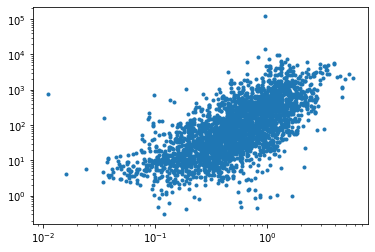

In [33]:
plt.plot(dfs[966][:len(a)],a['ebe_mmkyr'],'.')
plt.xscale('log')
plt.yscale('log')

In [13]:
Gs

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [43]:
np.argmin(np.abs(ns-1.9286))

126

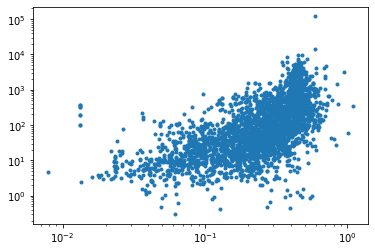

In [54]:
plt.plot(slpsall[:len(a)],a['ebe_mmkyr'],'.')
plt.xscale('log')
plt.yscale('log')
#plt.plot(np.log(dfs[np.argmax(a)]))

In [52]:
diffus[np.argmax(r2s)]

3.804728305633972e-05

In [ ]:
# from sklearn import linear_model as lm
# import sklearn
# r2s = np.zeros((len(ms),len(ns)))
# for i in range(20):#range(len(ms)):
#     for j in range(16):#range(len(ns)):
#         if dfs[i,j] is None:
#             continue
    
#         y = np.log(np.float64(a['ebe_mmkyr'])/1000)
#         x = np.log(dfs[i,j])
#         I_min = np.where(a['slp_ave'][:n]/1000>1e-1)[0]
#         x=x[I_min]
#         y=y[I_min]
#         xi = x.copy()
#         I = np.where(np.logical_or(np.isnan(x),np.isinf(x)))[0]
#         x=np.delete(x,I)
#         y=np.delete(y,I)
#         I2 = np.where(np.logical_or(np.isnan(y),np.isnan(x)))[0]
#         x = np.delete(x,I2)
#         y = np.delete(y,I2)
#         l  = lm.LinearRegression()
#         if (len(x)==0) or (len(y)==0):
#             continue
#         p = l.fit(x.reshape(-1,1),y.reshape(-1,1))
#         y2 = p.predict(x.reshape(-1,1))
#         r2s[i,j]=sklearn.metrics.r2_score(y.reshape(-1,1),y2)


(array([228.,  16.,  13.,  16.,  14.,   7.,   3.,   3.,   4.,   4.]),
 array([1.13918299e-07, 9.13308192e-02, 1.82661524e-01, 2.73992230e-01,
        3.65322935e-01, 4.56653640e-01, 5.47984346e-01, 6.39315051e-01,
        7.30645756e-01, 8.21976461e-01, 9.13307167e-01]),
 <BarContainer object of 10 artists>)

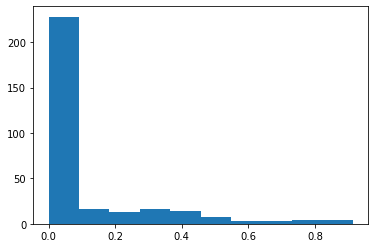

In [84]:
plt.hist(diffus[np.logical_and(r2s<.38,r2s>.36)])

In [15]:
a['ksn'] = a['ebe_mmkyr'].to_numpy()/dfs[4,5][:len(a)]
a.to_file('octo_327_data/')
plt.plot(a['ksn'],a['ebe_mmkyr'],'.')
plt.yscale('log')
plt.xscale('log')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [73]:
plt.plot(dfs[4,10],a['ebe_mmkyr'],'.')
plt.yscale('log')
plt.xscale('log')
plt.xlim([10e-11,10e-5])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

0.31561967388953904

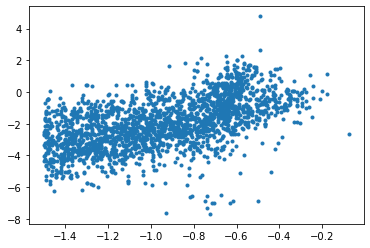

In [13]:
y = np.log(np.float64(a['ebe_mmkyr'])/1000)
x = np.log(np.float64(a['slp_ave'][:n]/1000))
I0 = np.where(x<-1.5)[0]
xi = x.copy()
x = np.delete(x,I0)
y = np.delete(y,I0)
I = np.where(np.logical_or(np.isnan(x),np.isinf(x)))[0]
x=np.delete(x,I)
y=np.delete(y,I)
I2 = np.where(np.logical_or(np.isnan(y),np.isnan(x)))[0]
x = np.delete(x,I2)
y = np.delete(y,I2)
l  = lm.LinearRegression()
p = l.fit(x.reshape(-1,1),y.reshape(-1,1))
y2 = p.predict(x.reshape(-1,1))
plt.plot(x,y,'.')
sklearn.metrics.r2_score(y.reshape(-1,1),y2)


ValueError: x and y must have same first dimension, but have shapes (19, 41) and (3553,)

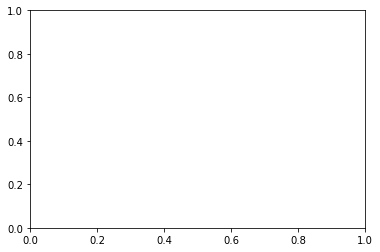

In [72]:
plt.plot(slps1,a['ebe_mmkyr'],'.')
plt.xscale('log')
plt.yscale('log')

In [ ]:
y = np.log(np.float64(a['ebe_mmkyr'])/1000)
x = np.log(np.float64(a['slps1']))
xi = x.copy()
I = np.where(np.logical_or(np.isnan(x),np.isinf(x)))[0]
x=np.delete(x,I)
y=np.delete(y,I)
I2 = np.where(np.logical_or(np.isnan(y),np.isnan(x)))[0]
x = np.delete(x,I2)
y = np.delete(y,I2)
l  = lm.LinearRegression()
p = l.fit(x.reshape(-1,1),y.reshape(-1,1))
y2 = p.predict(x.reshape(-1,1))
sklearn.metrics.r2_score(y.reshape(-1,1),y2)

In [15]:
#ax=plt.plot(eros1[:len(a)],a['ebe_gcmyr']/1000,'.')
slps_ = slps1
slps_[slps_<1e-6] = np.nan
ax=plt.plot(eros1[len(a)],a['ebe_gcmyr'][/1000,'.')
plt.yscale('log')
plt.xscale('log')
#plt.xlim([1e-2, 1])
#plt.ylim([1e-2, 1])

#a['ebe_gcmyr'][a['erorate_est']<=0] = np.nan

SyntaxError: invalid syntax (<ipython-input-15-e6381bda8298>, line 4)

In [20]:
r2s

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
from sklearn import linear_model as lm
ax=plt.plot(slps1[1:3500],np.float64(a['ebe_mmkyr'][1:3500])/1000,'.')
erate = np.float64(a['ebe_mmkyr'][1:n])/1000
slps1 = slps1[1:n]
I = np.where(slps1 ==0)
np.delete(slps1,I)
slps1 = erate = np.delete(erate,I)
I2 = np.where(np.isnan(erate))
slps1 = np.delete(slps1,I2)
erate = np.delete(erate,I2)
l  = lm.LinearRegression()
l.fit(slps1.reshape(-1,1),erate.reshape(-1,1))
plt.yscale('log')
plt.xscale('log')

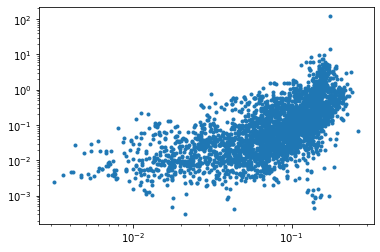

In [47]:
ax=plt.plot(np.float64(a['slp_ave'][1:3500]/3500),np.float64(a['ebe_mmkyr'][1:3500])/1000,'.')
plt.yscale('log')
plt.xscale('log')

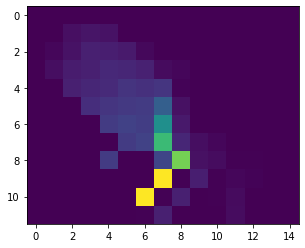

In [109]:
plt.imshow(f.A)

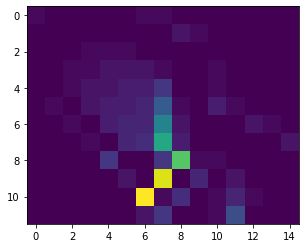

In [114]:
plt.imshow(A)

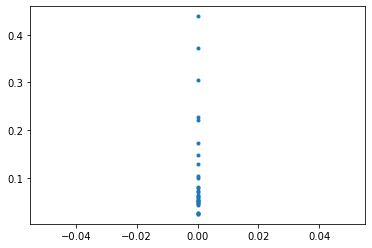

In [40]:
#ax=plt.plot(eros1[:len(a)],a['ebe_gcmyr']/1000,'.')
#ax=plt.plot(slps1[:len(a)],a['slp_ave'],'.')
ax=plt.plot(eros1[:30],np.float64(a['slp_ave'][:30])/1000,'.')

#plt.yscale('log')
#plt.xscale('log')
#plt.xlim([5e-4, 1])

In [119]:
np.argmax(np.abs(slps1[1:30] - np.float64(a['slp_ave'][1:30])))

28

NameError: name 'dfs' is not defined

In [ ]:
import seaborn as sns

In [ ]:
a.columns